# k-Nearest Neighbors

## Imports


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

## Student Dataset Class (From Q1)

In [8]:
username = "sudershan.sarraf" 
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)

class StudentDataset:
    def __init__(self, num_students: int, seed: int):
        self.num_students = num_students
        self.rng = np.random.default_rng(seed)
        self.username = username
        self._full_df = self._assemble_dataframe()
    def get_full_dataframe(self) -> pd.DataFrame: return self._full_df.copy()
    def _generate_gender(self) -> list[str]: return self.rng.choice(["Male", "Female", "Other"], self.num_students, p=[0.65, 0.33, 0.02])
    def _generate_major(self) -> list[str]: return self.rng.choice(["B.Tech", "MS", "PhD"], self.num_students, p=[0.70, 0.20, 0.10])
    def _generate_program(self, majors: list[str]) -> list[str]:
        p_dist = {"B.Tech": {"choices": ["CSE", "ECE", "CHD", "CND"], "probs": [0.4, 0.4, 0.1, 0.1]}, "MS": {"choices": ["CSE", "ECE", "CHD", "CND"], "probs": [0.3, 0.3, 0.2, 0.2]}, "PhD": {"choices": ["CSE", "ECE", "CHD", "CND"], "probs": [0.25, 0.25, 0.25, 0.25]}}
        return [self.rng.choice(p_dist[m]["choices"], p=p_dist[m]["probs"]) for m in majors]
    def _generate_gpa(self, majors: list[str]) -> list[float]:
        g_dist = {"B.Tech": {"mean": 7.0, "std": 1.0}, "MS": {"mean": 8.0, "std": 0.7}, "PhD": {"mean": 8.3, "std": 0.5}}
        gpas = [self.rng.normal(loc=g_dist[m]["mean"], scale=g_dist[m]["std"]) for m in majors]
        return np.clip(gpas, 4.0, 10.0).tolist()
    def _assemble_dataframe(self) -> pd.DataFrame:
        majors = self._generate_major()
        return pd.DataFrame({'gender': self._generate_gender(), 'major': majors, 'program': self._generate_program(majors), 'gpa': self._generate_gpa(majors)})

# Create the necessary DataFrame for Q2
dataset = StudentDataset(num_students=10000, seed=seed)
df_full = dataset.get_full_dataframe()


## Feature Transformations

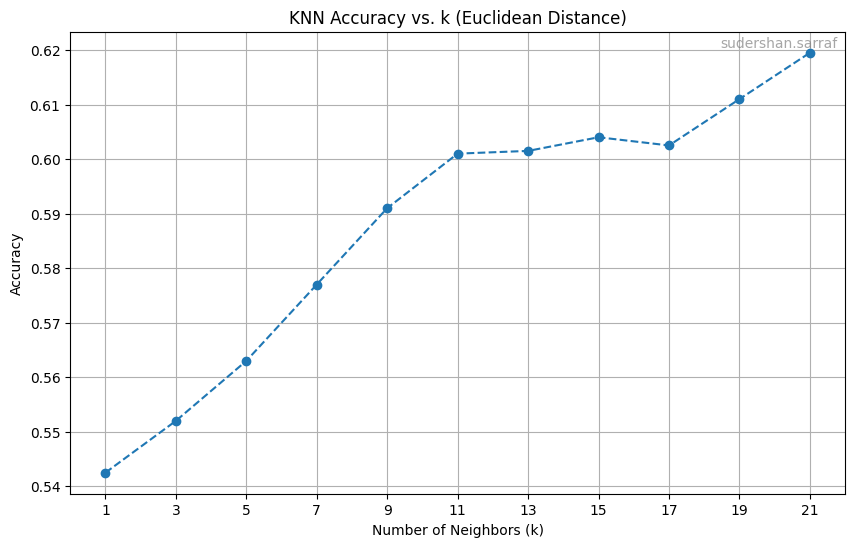

Best k for Euclidean distance: 21



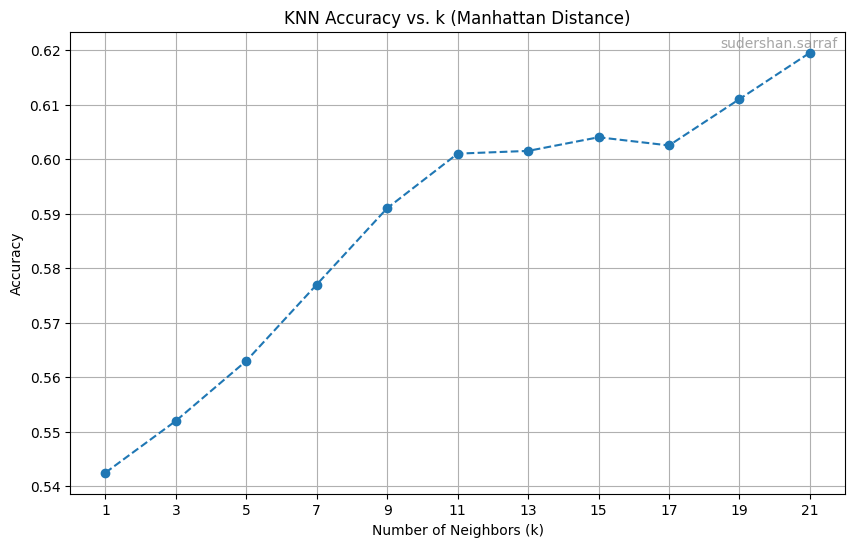

Best k for Manhattan distance: 21



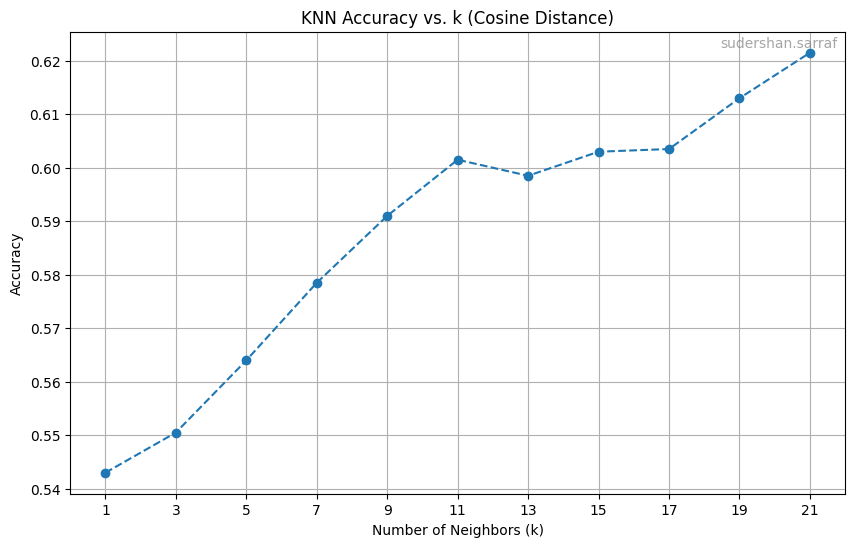

Best k for Cosine distance: 21

Validation F1-Scores:
    euclidean  manhattan  cosine
1      0.5372     0.5372  0.5376
3      0.5359     0.5359  0.5345
5      0.5365     0.5365  0.5375
7      0.5380     0.5380  0.5402
9      0.5489     0.5489  0.5493
11     0.5503     0.5503  0.5519
13     0.5394     0.5394  0.5375
15     0.5407     0.5407  0.5400
17     0.5324     0.5324  0.5345
19     0.5314     0.5314  0.5328
21     0.5303     0.5303  0.5333


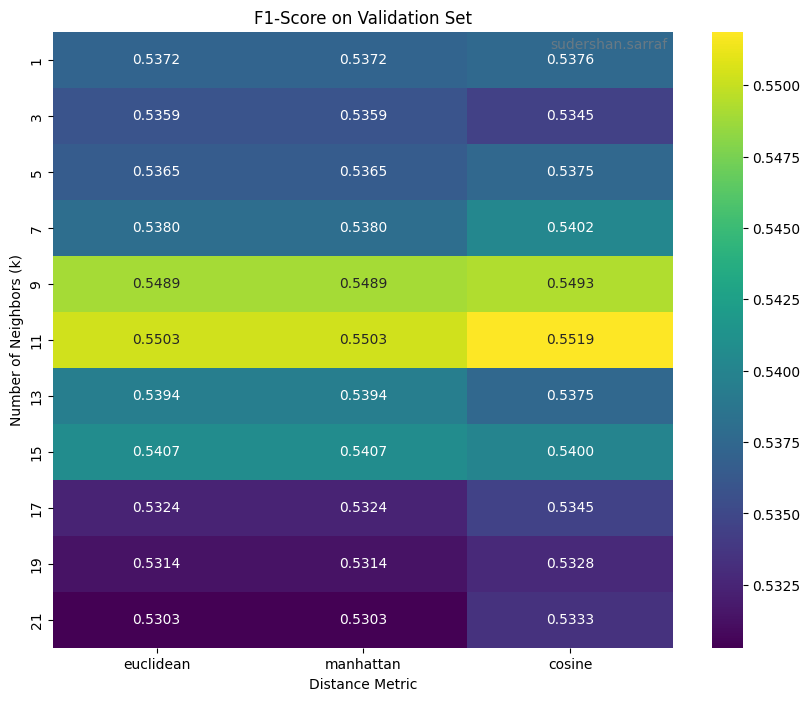

Best performing metric: 'Cosine' with k=11

F1-Scores on Test Set using single features (Cosine distance):
       gpa   major  program
1   0.4923  0.2649   0.3179
3   0.5033  0.2649   0.5301
5   0.5033  0.2649   0.5301
7   0.5033  0.2649   0.5301
9   0.5033  0.4017   0.5301
11  0.5033  0.4017   0.5301
13  0.5033  0.4017   0.5033
15  0.4923  0.4017   0.5301
17  0.4923  0.4017   0.5301
19  0.4923  0.4017   0.5301
21  0.4923  0.4017   0.5301

Best single feature: 'program' (F1-score: 0.5301)
F1-score with all features on the test set: 0.5404


In [14]:
class PerFeatureTransformer:
    """A class to handle fitting and transforming features based on specified types."""
    def __init__(self):
        """Initializes memory for per-feature transformers."""
        self.preprocessor = None
        self.params = None

    def fit(self, df: pd.DataFrame, params: dict[str, str]):
        """Fits transformers for each feature based on the given type."""
        self.params = params
        transformers = []
        type_to_features = {'standard': [], 'ordinal': [], 'onehot': []}
        for feature, f_type in params.items():
            if f_type in type_to_features:
                type_to_features[f_type].append(feature)

        # Append transformers based on their type.
        if type_to_features['standard']:
            transformers.append(('standard', StandardScaler(), type_to_features['standard']))
        if type_to_features['ordinal']:
            transformers.append(('ordinal', OrdinalEncoder(), type_to_features['ordinal']))
        if type_to_features['onehot']:
            transformers.append(('onehot', OneHotEncoder(handle_unknown='ignore'), type_to_features['onehot']))
            
        self.preprocessor = ColumnTransformer(transformers, remainder='passthrough')
        self.preprocessor.fit(df)

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        """Applies the fitted transformers to the corresponding features."""
        return self.preprocessor.transform(df)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) -> np.ndarray:
        """Fits and transforms all features in one step."""
        self.fit(df, params)
        return self.transform(df)

class KNNGenderPredictor:
    """A class to predict gender using KNN."""
    def __init__(self, student_df: pd.DataFrame, username: str):
        """Initializes the predictor with the full student dataset."""
        self.full_df = student_df
        self.username = username
        self.transformer = PerFeatureTransformer()
        self.X_train, self.X_val, self.X_test = None, None, None
        self.y_train, self.y_val, self.y_test = None, None, None
        self.features = ['gpa', 'major', 'program']

    def _add_username_to_plot(self, ax):
        ax.text(0.99, 0.99, self.username,
                ha='right', va='top', transform=ax.transAxes,
                fontsize=10, color='gray', alpha=0.7)

    def train_val_test_split(self, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42):
        """Splits the data into training, validation, and test sets."""
        # Stratify by gender to maintain the same class distribution in splits.
        train_val_df, test_df = train_test_split(
            self.full_df, test_size=test_size, random_state=seed, stratify=self.full_df['gender']
        )
        relative_val_size = val_size / (1 - test_size)
        train_df, val_df = train_test_split(
            train_val_df, test_size=relative_val_size, random_state=seed, stratify=train_val_df['gender']
        )
        self.X_train, self.y_train = train_df[self.features], train_df['gender']
        self.X_val, self.y_val = val_df[self.features], val_df['gender']
        self.X_test, self.y_test = test_df[self.features], test_df['gender']

    def fit_and_transform_features(self, params: dict[str, str]):
        """Fits the transformer on training data and transforms all sets."""
        self.transformer.fit(self.X_train, params)
        self.X_train_transformed = self.transformer.transform(self.X_train)
        self.X_val_transformed = self.transformer.transform(self.X_val)
        self.X_test_transformed = self.transformer.transform(self.X_test)

    def get_knn_accuracy_vs_k(self, k_values: list[int], distance: str = "euclidean") -> dict[int, float]:
        """Calculates accuracy scores for various k values on the validation set."""
        accuracies = {}
        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
            knn.fit(self.X_train_transformed, self.y_train)
            y_pred = knn.predict(self.X_val_transformed)
            accuracies[k] = accuracy_score(self.y_val, y_pred)
        return accuracies

    def plot_knn_accuracy_vs_k(self, accuracies: dict[int, float], distance: str):
        """Plots accuracy scores against k values on the validation set."""
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
        ax.plot(accuracies.keys(), accuracies.values(), marker='o', linestyle='--')
        ax.set_title(f'KNN Accuracy vs. k ({distance.capitalize()} Distance)')
        ax.set_xlabel('Number of Neighbors (k)'); ax.set_ylabel('Accuracy')
        self._add_username_to_plot(ax)
        plt.xticks(list(accuracies.keys())); plt.grid(True); plt.show()

    def get_knn_f1_heatmap(self, k_values: list[int], distances: list[str]) -> pd.DataFrame:
        """Returns a dataframe with the f1-score for each combination on the validation set."""
        f1_scores = pd.DataFrame(index=k_values, columns=distances)
        for dist in distances:
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=dist)
                knn.fit(self.X_train_transformed, self.y_train)
                y_pred = knn.predict(self.X_val_transformed)
                # Use 'weighted' F1 for imbalanced multi-class problems.
                f1_scores.loc[k, dist] = f1_score(self.y_val, y_pred, average='weighted')
        return f1_scores.astype(float)

    def plot_knn_f1_heatmap(self, f1_scores_df: pd.DataFrame):
        """Plots a heatmap of k x distance function vs. F-1 score."""
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(f1_scores_df, annot=True, fmt=".4f", cmap="viridis")
        ax.set_title('F1-Score on Validation Set')
        ax.set_xlabel('Distance Metric'); ax.set_ylabel('Number of Neighbors (k)')
        self._add_username_to_plot(ax)
        plt.show()

    def get_knn_f1_single_feature_table(self, k_values: list[int], distance: str = "euclidean") -> pd.DataFrame:
        """Creates a table of F1 scores on the test set using only a single feature."""
        f1_table = pd.DataFrame(index=k_values, columns=self.features)
        for feature in self.features:
            temp_transformer = PerFeatureTransformer()
            # Use .iloc[0] to get the dtype and silence the FutureWarning.
            params = {feature: 'standard' if self.X_train[[feature]].dtypes.iloc[0] != 'object' else 'onehot'}
            X_train_single = temp_transformer.fit_transform(self.X_train[[feature]], params)
            X_test_single = temp_transformer.transform(self.X_test[[feature]])
            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
                knn.fit(X_train_single, self.y_train)
                y_pred = knn.predict(X_test_single)
                f1_table.loc[k, feature] = f1_score(self.y_test, y_pred, average='weighted')
        return f1_table.astype(float)

predictor = KNNGenderPredictor(df_full, username)

predictor.train_val_test_split()
feature_params = {'gpa': 'standard', 'major': 'onehot', 'program': 'onehot'}
predictor.fit_and_transform_features(params=feature_params)

k_values = list(range(1, 22, 2))

# Euclidean Analysis
euclidean_accuracies = predictor.get_knn_accuracy_vs_k(k_values, distance='euclidean')
predictor.plot_knn_accuracy_vs_k(euclidean_accuracies, distance='euclidean')
best_k_euclidean = max(euclidean_accuracies, key=euclidean_accuracies.get)
print(f"Best k for Euclidean distance: {best_k_euclidean}\n")

# Manhattan Analysis
manhattan_accuracies = predictor.get_knn_accuracy_vs_k(k_values, distance='manhattan')
predictor.plot_knn_accuracy_vs_k(manhattan_accuracies, distance='manhattan')
best_k_manhattan = max(manhattan_accuracies, key=manhattan_accuracies.get)
print(f"Best k for Manhattan distance: {best_k_manhattan}\n")

# Cosine Analysis
cosine_accuracies = predictor.get_knn_accuracy_vs_k(k_values, distance='cosine')
predictor.plot_knn_accuracy_vs_k(cosine_accuracies, distance='cosine')
best_k_cosine = max(cosine_accuracies, key=cosine_accuracies.get)
print(f"Best k for Cosine distance: {best_k_cosine}\n")

distances = ['euclidean', 'manhattan', 'cosine']
f1_df = predictor.get_knn_f1_heatmap(k_values, distances)
print("Validation F1-Scores:")
print(f1_df.round(4))
predictor.plot_knn_f1_heatmap(f1_df)

best_metric = f1_df.max().idxmax()
best_k = f1_df[best_metric].idxmax()
print(f"Best performing metric: '{best_metric.capitalize()}' with k={best_k}\n")

f1_single_feature = predictor.get_knn_f1_single_feature_table(k_values, distance=best_metric)
print(f"F1-Scores on Test Set using single features ({best_metric.capitalize()} distance):")
print(f1_single_feature.round(4))

best_single_feature = f1_single_feature.max().idxmax()
best_single_feature_score = f1_single_feature.max().max()
print(f"\nBest single feature: '{best_single_feature}' (F1-score: {best_single_feature_score:.4f})")

# Final evaluation on the test set using the best k and metric.
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn_final.fit(predictor.X_train_transformed, predictor.y_train)
y_pred_test = knn_final.predict(predictor.X_test_transformed)
f1_all_features = f1_score(predictor.y_test, y_pred_test, average='weighted')
print(f"F1-score with all features on the test set: {f1_all_features:.4f}")


## Q2.0 KNN Observations
Best k based on Accuracy
The accuracy-vs-k plots show the k value that achieves the highest simple accuracy for each metric on the validation set:

For Euclidean distance, the best k for accuracy is 21.

For Manhattan distance, the best k for accuracy is 21.

For Cosine distance, the best k for accuracy is 21.

## Best Overall Metric (based on F1-Score)
The F1-score is a more robust metric for this problem because the gender classes are imbalanced. The F1-score heatmap shows that Cosine distance performs the best overall, with its peak F1-score at k=11. We will use these parameters (Cosine, k=11) for the final evaluation.

## Single Feature Performance
When evaluating features individually on the test set (using Cosine, k=11), 'program' was the most predictive single feature, achieving a max F1-score of approximately 0.5301.

## Final Comparison
The model using all features (gpa, major, program) with the best parameters achieved a final F1-score of approximately 0.5404 on the test set. This is better than the score from the best single feature ('program'). This confirms that while 'program' is the most important single predictor in this run, the other features provide complementary information that helps the model make more accurate predictions.